In [104]:
from astropy.io import fits
from astropy.utils.data import download_file
from astropy.table import Table
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle

In [102]:
image_file = download_file('https://data.sdss.org/sas/dr16/apogee/spectro/aspcap/r12/l33/allStar-r12-l33.fits', cache=True )
Apogee16 = Table.read(image_file, hdu=1)

horse_file = download_file('https://data.sdss.org/sas/dr16/apogee/vac/apogee-starhorse/apogee_starhorse-DR16.fits', cache=True)
hdu_list = fits.open(horse_file)
StarHorse = hdu_list[1].data

# Data Cleaning
## Crossmatching Starhorse and Apogee dr16

In [225]:
i = 0

distance05 = []
distance50 = []
distance95 = []

for star in Apogee16['APOGEE_ID']:
    if i % 50000 == 0: 
        print(i / len(Apogee16['APOGEE_ID']))
    if star in StarHorse['APOGEE_ID']:
        distance05.append(StarHorse['dist05'][StarHorse['APOGEE_ID'] == star][0])
        distance50.append(StarHorse['dist50'][StarHorse['APOGEE_ID'] == star][0])
        distance95.append(StarHorse['dist95'][StarHorse['APOGEE_ID'] == star][0])
    else: 
        distance05.append(-9999)
        distance50.append(-9999)
        distance95.append(-9999)
        
    i+=1
    
Apogee16['distance05'] = distance05
Apogee16['distance50'] = distance50
Apogee16['distance95'] = distance95

0.0
0.10563967995402561
0.21127935990805122
0.3169190398620768
0.42255871981610243
0.5281983997701281
0.6338380797241536
0.7394777596781793
0.8451174396322049
0.9507571195862305


In [ ]:
pickle.dump(Apogee16,open("Apogee_horse.pickle", "wb"))

## Choosing elements and removing bad values

In [226]:
elements = ['C_FE', 'CI_FE', 'N_FE', 'O_FE', 'NA_FE', 'MG_FE', 'AL_FE', 'SI_FE', 'P_FE', 'S_FE', 'K_FE', 'CA_FE',
            'TI_FE', 'TIII_FE', 'V_FE', 'CR_FE', 'MN_FE', 'FE_H', 'CO_FE', 'NI_FE', 'CU_FE', 'GE_FE', 'RB_FE',
            'CE_FE', 'ND_FE', 'YB_FE']

for e in elements: 
    print(e + ": "+ str(sum(Apogee16[e] < -900)/len(Apogee16)))
    
# choose elements that have at least 50% good values
elements_used = ['C_FE', 'CI_FE', 'N_FE', 'O_FE', 'NA_FE', 'MG_FE', 'AL_FE', 'SI_FE', 'P_FE', 'S_FE', 'K_FE', 
                 'CA_FE', 'TI_FE', 'TIII_FE', 'CR_FE', 'MN_FE', 'FE_H', 'CO_FE', 'NI_FE', 'CU_FE']

good_inds = (Apogee16['distance05']>-900) & (Apogee16['distance50']>-900) & (Apogee16['distance95']>-900)
for e in elements_used: 
    good_inds = good_inds & (Apogee16[e]>-900)
    
data = Apogee16[good_inds]

C_FE: 0.13226087930244007
CI_FE: 0.13461241857821668
N_FE: 0.17181660106442542
O_FE: 0.35604586452344883
NA_FE: 0.46301026606409795
MG_FE: 0.12841559495211352
AL_FE: 0.1358864331184622
SI_FE: 0.12824868425778618
P_FE: 0.4335642616737128
S_FE: 0.19639472900252902
K_FE: 0.25818760339483676
CA_FE: 0.13140308510121337
TI_FE: 0.3738736169124902
TIII_FE: 0.46105381919134936
V_FE: 0.5381919134937789
CR_FE: 0.19340090047263192
MN_FE: 0.25372115772638054
FE_H: 0.12816628530742202
CO_FE: 0.20996520228942314
NI_FE: 0.12872828840477746
CU_FE: 0.2601905317267651
GE_FE: 1.0
RB_FE: 1.0
CE_FE: 0.5889686820604808
ND_FE: 1.0
YB_FE: 1.0


## Removing duplicate stars

In [227]:
import collections

counter_dict = collections.Counter(data['APOGEE_ID'])
apogee_ids = counter_dict.keys() 

c = 0 
removers = []

for star_id in apogee_ids:
    if counter_dict[star_id] > 1: 
        where_star = np.where(data['APOGEE_ID'] == star_id)
        total_var = []
        for s in range(len(where_star[0])):
            var_star = 0
            for e in elements_used: 
                var_star += data[e + '_ERR'][where_star[0][s]]**2
            total_var.append(var_star)
        c += 1
        removers.append(where_star[0][np.argmax(total_var)])
        
data.remove_rows(removers)

In [203]:
pickle.dump(data,open("apogee_clean.pickle", "wb"))

# Analysis

In [204]:
apogee16 = pickle.load(open("apogee_clean.pickle", "rb"))

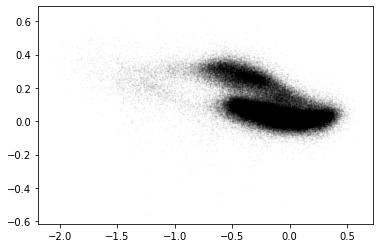

In [228]:
plt.scatter(apogee16['FE_H'], apogee16['MG_FE'], alpha=0.025, s=1, color='black')